## CHAAYA GIRIMON GH1027231

### PROBLEM STATEMENT:
The company has historical data with handwritten records and would like to digitize these records. Hence it is important to recognize handwritten characters accurately for improving data efficieny and reducing manual errors (Rosebrock, A. (2020)). 

This helps the company by automating document processing and helps in making data retrieval faster and more reliable.

### DATASET:
datasets can be found at: 
- https://www.kaggle.com/datasets/landlord/handwriting-recognition/code
- https://www.kaggle.com/datasets/vaibhao/handwritten-characters

### EXPERIMENTAL SECTION
The experimental section can be found in this repository: https://github.com/chaayagirimon/handwriting-recognition under the experimental.ipynb python notebook

In [1]:
import random
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np
import pandas as pd
import imutils
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense, MaxPooling2D, Dropout, Conv2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-07-04 17:15:00.560290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
img_size = 32 # reducing img size to prevent overloading
non_chars = ["#","$","&","@"] # dataset has these non-characters which are not required hence will be removed

In [3]:
def get_data(dir_,len_):
    temp = []
    for i in os.listdir(dir_):
        if i in non_chars:
            continue
        count = 0
        sub_directory = os.path.join(dir_,i)
        for j in os.listdir(sub_directory):
            count+=1
            if count > len_:
                break
            img = cv2.imread(os.path.join(sub_directory,j),0)
            img = cv2.resize(img,(img_size,img_size))
            temp.append([img,i])
            
    return temp

# use incase .DS_Store appears in the directory
# try:
# except NotADirectoryError as err:
#     print(str(err).split(":")[1].replace("'","").replace(" ",""))
#     os.remove(str(err).split(":")[1].replace("'","").replace(" ",""))

In [4]:
# getting 4000 and 1000 images respectively so as to not overload the model
# laptop overheating
train_dir = "archive-1/Train/"
val_dir = "archive-1/Validation"
train_data = get_data(train_dir, 4000)
val_data = get_data(val_dir, 1000)

In [5]:
len(train_data)

140000

In [6]:
len(val_data)

15209

### DATA PREPROCESSING:

In [7]:
train_X = [features for features, label in train_data]
train_Y = [label for features, label in train_data]
val_X = [features for features, label in val_data]
val_Y = [label for features, label in val_data]

In [8]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [9]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [10]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [11]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [12]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


### EDA (EXPLORATORY DATA ANALYSIS)

**Displaying random characters from the dataset**

In [13]:
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])

print(f"Training Data: {train_df.shape}")
print(f"Validation Data: {val_df.shape}")

# train_df.to_csv("train_data.csv", index=False)
# val_df.to_csv("valid_data.csv", index=False)

Training Data: (140000, 2)
Validation Data: (15209, 2)


In [14]:
train_df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1,...",R
1,"[[2, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,...",R
2,"[[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0,...",R
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,...",R
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2,...",R


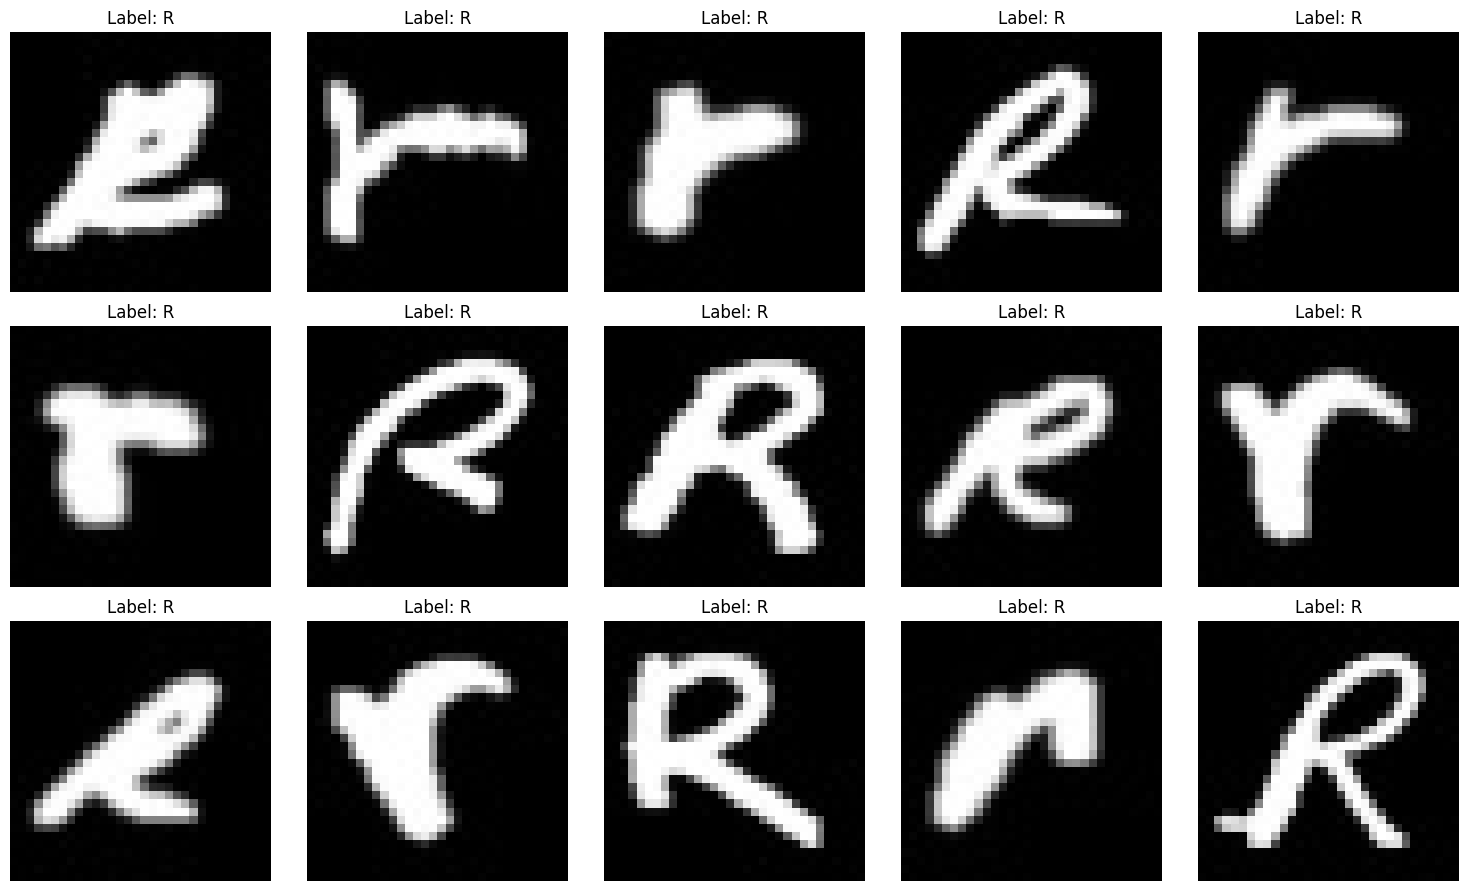

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    img = train_df.iloc[i]['image']
    label = train_df.iloc[i]['label']
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Distribution of the data**

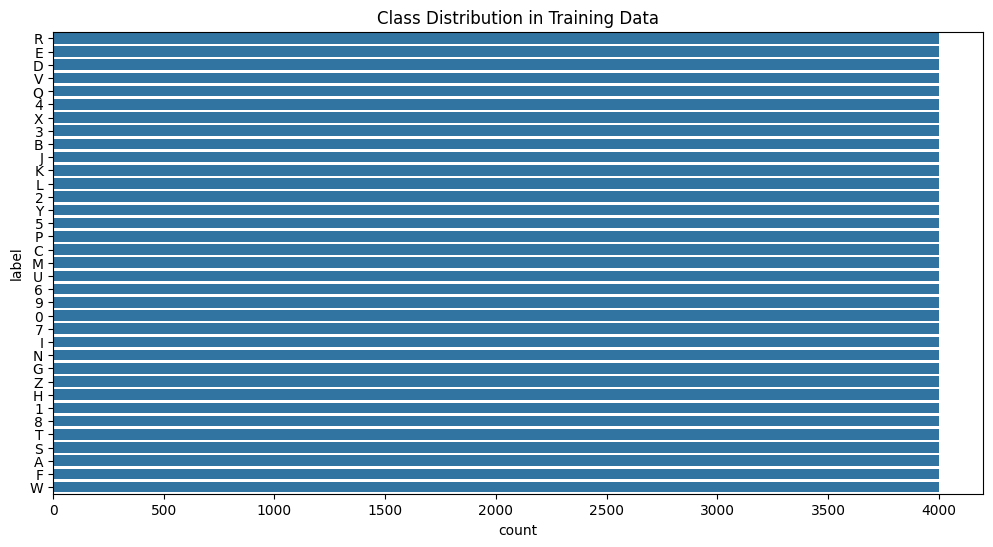

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.show()

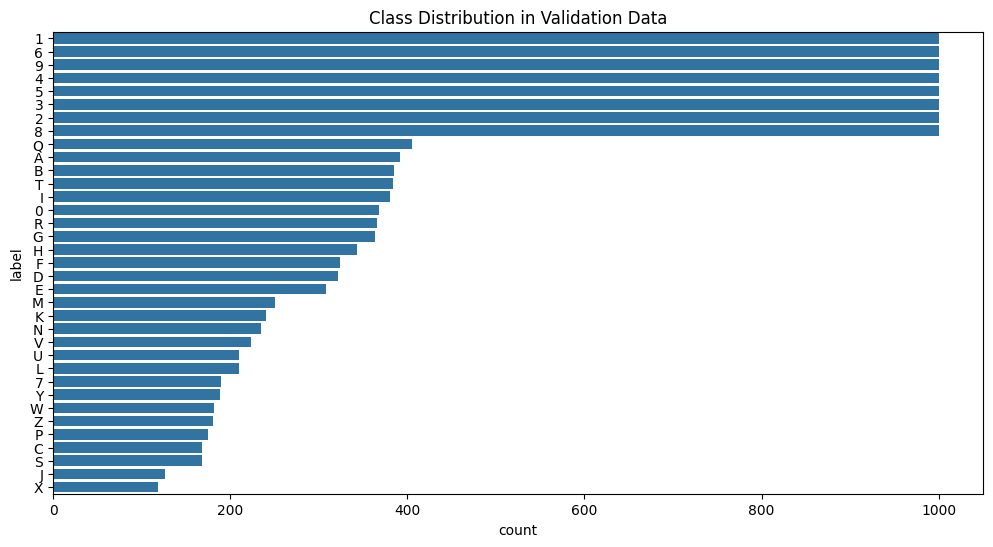

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(y=val_df['label'], order=val_df['label'].value_counts().index)
plt.title("Class Distribution in Validation Data")
plt.show()

### MODEL ASSESSMENT

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [20]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [21]:
history = model.fit(
    train_X,train_Y, 
    epochs=50, batch_size=32, 
    validation_data = (val_X, val_Y),  
    verbose=1)

Epoch 1/50
4375/4375 [==============================] - 123s 28ms/step - loss: 0.6100 - accuracy: 0.8056 - val_loss: 0.3463 - val_accuracy: 0.8843
Epoch 2/50
4375/4375 [==============================] - 128s 29ms/step - loss: 0.3436 - accuracy: 0.8838 - val_loss: 0.2826 - val_accuracy: 0.9029
Epoch 3/50
4375/4375 [==============================] - 132s 30ms/step - loss: 0.3004 - accuracy: 0.8971 - val_loss: 0.2750 - val_accuracy: 0.9071
Epoch 4/50
4375/4375 [==============================] - 136s 31ms/step - loss: 0.2765 - accuracy: 0.9047 - val_loss: 0.2585 - val_accuracy: 0.9106
Epoch 5/50
4375/4375 [==============================] - 139s 32ms/step - loss: 0.2558 - accuracy: 0.9116 - val_loss: 0.2589 - val_accuracy: 0.9070
Epoch 6/50
4375/4375 [==============================] - 143s 33ms/step - loss: 0.2444 - accuracy: 0.9149 - val_loss: 0.2271 - val_accuracy: 0.9218
Epoch 7/50
4375/4375 [==============================] - 145s 33ms/step - loss: 0.2349 - accuracy: 0.9182 - val_loss: 0

### VISUALISATION

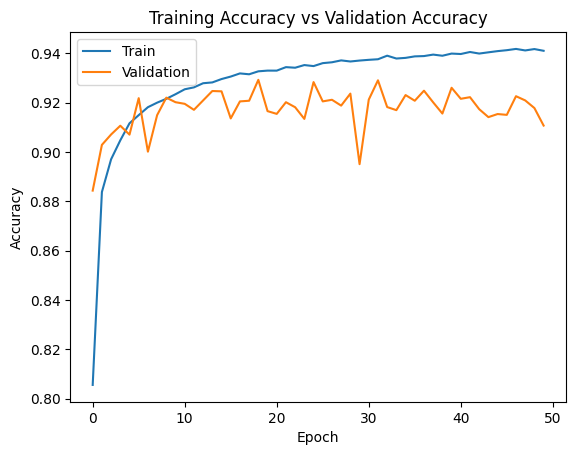

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

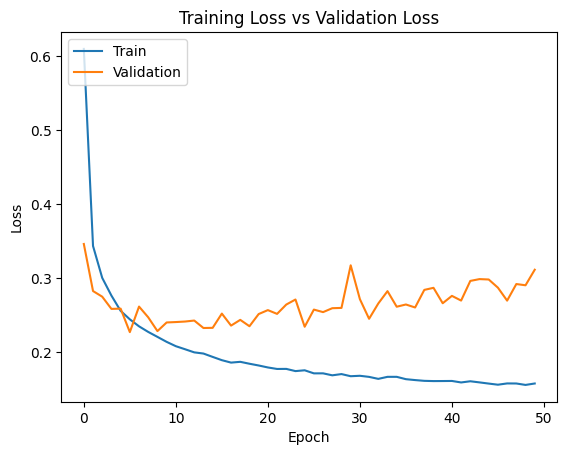

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### CHECKING FOR ACCURACY OF THE MODEL
Using the model to predict the names in the handwriting-recognition dataset.

In [24]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [25]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [26]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 17ms/step
LIL0U


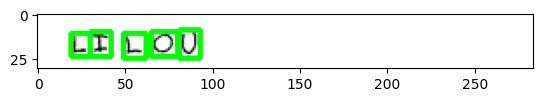

In [27]:
letter,image = get_letters("archive/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 143ms/step
LENA


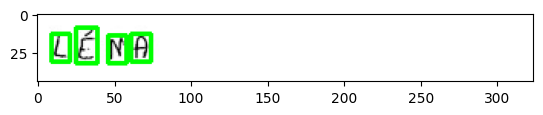

In [29]:
letter,image = get_letters("archive/test_v2/test/TEST_0003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

### DISCUSSIONS:
The model achieves high accuracy in recognizing hand written characters. Thus the model is capable of generalizing well to unlabelled/ unseen data.

But the model may struggle with highly variable handwriting styles that did nnot occur during training. For example in the last test we can see that the "É" gets interpreted without the accent. The performance could also not be optimal as the size was reduced to 32 for convenience purposes.

Implementing this recognition mode can have significant business benefits:
1. Improved customer service
2. Effecient Information retrieval
3. Greater accessability
4. Better data storage (Instabase (2024))

### RECOMMENDATIONS: 
Based on the model's performance possible recommendations would be:
- increase the size of the dataset to improove the accuracy of the model.
- Run the model in a system with a capable GPU.
- Human-in-the-Loop: For critical applications, use the model's predictions as a preliminary step and have human reviewers verify the results for improved accuracy (Parsio Blog. (2024)).

### REFERENCES:
Rosebrock, A. (2020). OCR: Handwriting recognition with OpenCV, Keras, and TensorFlow. [online] PyImageSearch. Available at: https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/.

Instabase (2024). Handwriting Recognition: Benefits, Challenges, and the Role of AI. [online] Instabase. Available at: https://instabase.com/blog/handwriting-recognition-ai/.

Parsio Blog. (2024). What is Human-in-the-Loop in Machine Learning? [online] Available at: https://parsio.io/blog/human-in-the-loop/ [Accessed 4 Jul. 2024].

